# Introduction

This notebook contains additional models, in particular simple RNN and LSTM. 

PART 0: 
Package and settings

PART 1: 
It describes the RNN model trained on the fcr storm.You will also find all the observations and comments about the strategy and the results.

PART 2: 
It describes the LSTM model with the same format as the first part. 

PART 3:
It shows the results on the surprise storm and the metrics we got.

PART 4:
This is a dissucssion about the different strategies to predict multiple time steps and provides some results with the two models.

# PART 0: Packages and settings 

In [ ]:
!pip install radiant_mlhub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 20.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchsummary import summary


import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms


from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import json
import re
from glob import glob
import tarfile

from radiant_mlhub import Dataset, Collection, client

pd.set_option("max_colwidth", 80)


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True
    
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading and preprocessing for the FCR storm 

As the prepocessing is similar for the RNN and LSTM model we will only do it once.

In [ ]:
#API key to load the data
import os
os.environ['MLHUB_API_KEY'] = '31515d4cedf0d09195561e058af6b0b6d35fa430c7b9e23f3b6d56758c29db88'

In [ ]:
#Get the list of all datasets available 
for dataset in Dataset.list():
    print(f'{dataset.id}: ({dataset.title})')

umd_mali_crop_type: (2019 Mali CropType Training Data)
idiv_asia_crop_type: (A crop type dataset for consistent land cover classification in Central Asia)
dlr_fusion_competition_germany: (A Fusion Dataset for Crop Type Classification in Germany)
ref_fusion_competition_south_africa: (A Fusion Dataset for Crop Type Classification in Western Cape, South Africa)
bigearthnet_v1: (BigEarthNet)
microsoft_chesapeake: (Chesapeake Land Cover)
ref_african_crops_kenya_02: (CV4A Kenya Crop Type Competition)
ref_african_crops_uganda_01: (Dalberg Data Insights Crop Type Uganda)
rti_rwanda_crop_type: (Drone Imagery Classification Training Dataset for Crop Types in Rwanda)
cgiar_east_africa_agricultural_field_centers: (East Africa Agricultural Field Centers)
ref_african_crops_tanzania_01: (Great African Food Company Crop Type Tanzania)
ref_landcovernet_af_v1: (LandCoverNet Africa)
ref_landcovernet_sa_v1: (LandCoverNet South America)
marida_v1: (Marine Debris Archive (MARIDA))
nasa_marine_debris: (Marin

In [ ]:
#Pick the tropical strom dataset

dataset = Dataset.fetch('nasa_tropical_storm_competition')

print('Source Imagery Collections\n--------------------------')
for collection in dataset.collections.source_imagery:
    print(collection.id)

print('')

print('Label Collections\n-----------------')
for collection in dataset.collections.labels:
    print(collection.id)

Source Imagery Collections
--------------------------
nasa_tropical_storm_competition_train_source
nasa_tropical_storm_competition_test_source

Label Collections
-----------------
nasa_tropical_storm_competition_train_labels
nasa_tropical_storm_competition_test_labels


In [ ]:
#Print the details and metadata
def print_summary(item, collection):
    print(f'Collection: {collection.id}')
    print(f'Item: {item["id"]}')
    print('Assets:')
    for asset_name, asset in item.get('assets', {}).items():
        print(f'- {asset_name}: {asset["title"]} [{asset["type"]}]')
    
    print('\n')

for collection in dataset.collections:
    item = next(client.list_collection_items(collection.id, limit=1))
    print_summary(item, collection)

Collection: nasa_tropical_storm_competition_train_source
Item: nasa_tropical_storm_competition_train_source_zzp_225
Assets:
- image: Hurricane Image [image/jpeg]
- features: Image Features [application/json]


Collection: nasa_tropical_storm_competition_test_source
Item: nasa_tropical_storm_competition_test_source_zza_178
Assets:
- image: Hurricane Image [image/jpeg]
- features: Image Features [application/json]


Collection: nasa_tropical_storm_competition_train_labels
Item: nasa_tropical_storm_competition_train_labels_zzp_225
Assets:
- labels: Wind Speed Label [application/json]


Collection: nasa_tropical_storm_competition_test_labels
Item: nasa_tropical_storm_competition_test_labels_zza_178
Assets:
- labels: Wind Speed Label [application/json]




In [ ]:
# # Use this to download the the typical Mac user Downloads folder
download_dir = Path('~/Downloads').expanduser().resolve()

In [ ]:
# NOTE: Extracting the archives takes a while so this cell may take 5-10 minutes to complete
archive_paths = dataset.download(output_dir=download_dir)
for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=download_dir)
print('Done')

  0%|          | 0/1446.5 [00:00<?, ?M/s]

  0%|          | 0/918.3 [00:00<?, ?M/s]

  0%|          | 0/7.5 [00:00<?, ?M/s]

  0%|          | 0/4.6 [00:00<?, ?M/s]

Extracting /root/Downloads/nasa_tropical_storm_competition_train_source.tar.gz...
Extracting /root/Downloads/nasa_tropical_storm_competition_test_source.tar.gz...
Extracting /root/Downloads/nasa_tropical_storm_competition_train_labels.tar.gz...
Extracting /root/Downloads/nasa_tropical_storm_competition_test_labels.tar.gz...
Done


In [ ]:
train_data = []

train_source = 'nasa_tropical_storm_competition_train_source'
train_labels = 'nasa_tropical_storm_competition_train_labels'

jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    #print(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)
    file_name = jpg_path

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed']),
        file_name
    ])

train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'Wind Speed', 'File']
).sort_values(by=['Image ID']).reset_index(drop=True)

train_df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,File
0,abs_000,abs,0,2,43,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
1,abs_001,abs,1800,2,44,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
2,abs_002,abs,5400,2,45,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
3,abs_003,abs,17999,2,52,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
4,abs_004,abs,19799,2,53,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...


In [ ]:
test_data = []

test_source = 'nasa_tropical_storm_competition_test_source'
test_labels = '/content/nasa_tropical_storm_competition_surprise_storm_labels.tar.gz'
jpg_names = glob(str(download_dir / test_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    file_name = jpg_path
    

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)

    test_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        file_name,
        
    ])

test_df = pd.DataFrame(
    np.array(test_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'File']
).sort_values(by=['Image ID']).reset_index(drop=True)

test_df.head()

,Image ID,Storm ID,Relative Time,Ocean,File
0,acd_123,acd,304198,1,/root/Downloads/nasa_tropical_storm_competition_test_source/nasa_tropical_st...
1,acd_124,acd,305998,1,/root/Downloads/nasa_tropical_storm_competition_test_source/nasa_tropical_st...
2,acd_125,acd,307798,1,/root/Downloads/nasa_tropical_storm_competition_test_source/nasa_tropical_st...
3,acd_126,acd,309598,1,/root/Downloads/nasa_tropical_storm_competition_test_source/nasa_tropical_st...
4,acd_127,acd,313198,1,/root/Downloads/nasa_tropical_storm_competition_test_source/nasa_tropical_st...


In [ ]:
from IPython.display import Image

In [ ]:
fcr_dataframe = train_df[train_df["Storm ID"] == 'fcr']
fcr_dataframe

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,File
14886,fcr_000,fcr,0,1,25,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
14887,fcr_001,fcr,1800,1,25,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
14888,fcr_002,fcr,3600,1,25,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
14889,fcr_003,fcr,5401,1,25,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
14890,fcr_004,fcr,7200,1,25,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
...,...,...,...,...,...,...
15529,fcr_643,fcr,1393200,1,20,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
15530,fcr_644,fcr,1395000,1,20,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
15531,fcr_645,fcr,1396800,1,20,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...
15532,fcr_646,fcr,1398601,1,20,/root/Downloads/nasa_tropical_storm_competition_train_source/nasa_tropical_s...


In [ ]:
from PIL import Image as pil_image

In [ ]:
# Each storm is sorted by relative time
# Identify the final 20% of images per storm
rows = fcr_dataframe.shape [0]
cols= fcr_dataframe.shape[1]

split = int(rows*0.8)


train_dataframe = fcr_dataframe.iloc[:split] #contains 80% of the data, the most ancient

val_dataframe = fcr_dataframe.iloc[split+1 :] #contains 20% of the data, the most recent

# Confirm pct of images in the validation set is approximately 20%
len(val_dataframe) / len(fcr_dataframe) * 100


19.90740740740741

In [ ]:
data_path = '/root/Downloads/nasa_tropical_storm_competition_train_source'
def loader(path):
    return pil_image.open(path)

transform_2 = transforms.Compose([
        # 3 layers allow for more params for training?
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Resize(128),
        
    ])

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


train_set_folder = ImageFolder('/root/Downloads/nasa_tropical_storm_competition_train_source/', transform=transform_2)

test_set_folder = ImageFolder('/root/Downloads/nasa_tropical_storm_competition_test_source/', transform=transform_2)


# Validation and train dataset

In [ ]:
# Define the x_train and the y_train set
# The y_train is the x_train with one step ahead
x_train = torch.asarray([train_set_folder[a][0].numpy() for a in list(fcr_dataframe.index)[:split]])
y_train = torch.asarray([train_set_folder[a+1][0].numpy() for a in list(fcr_dataframe.index)[:split]])

In [ ]:
# Define the validation set in the same way
x_val = torch.asarray([train_set_folder[a][0].numpy() for a in list(fcr_dataframe.index)[split+1:-1]])
y_val = torch.asarray([train_set_folder[a][0].numpy() for a in list(fcr_dataframe.index)[split+2:]])



In [ ]:
#Check the sizes 
print(x_train.shape) 
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

torch.Size([518, 1, 128, 128])
torch.Size([518, 1, 128, 128])
torch.Size([128, 1, 128, 128])
torch.Size([128, 1, 128, 128])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
#Create train tensor
train_ts = TensorDataset(x_train, y_train)

print('Lenght of train Tensor Dataset', len(train_ts))
print('Size of tensors in the dataset', train_ts[0][0].shape, train_ts[0][1].shape)

# Create validation tensor 
val_ts = TensorDataset(x_val, y_val)
print('Lenght of validation Tensor Dataset', len(val_ts))
print("Size of tensors in the dataset", val_ts[0][0].shape)


Lenght of train Tensor Dataset 518
Size of tensors in the dataset torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
Lenght of validation Tensor Dataset 128
Size of tensors in the dataset torch.Size([1, 128, 128])


In [ ]:
# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_ts,batch_size=1,num_workers=2)

val_dataloader = DataLoader(val_ts, batch_size = 1, num_workers = 2)

# PART 1 : RNN MODEL

# Define the neural network 

Before using the code provided to get the metrics of the surprise storm we used the SSIM from torchmetrics package.

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 4.8 MB/s 


In [ ]:
from torchmetrics import StructuralSimilarityIndexMeasure 
ssim = StructuralSimilarityIndexMeasure()
#SSIM_metrics(y_val[-1],outputs_)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
def SSIM_metrics(original, prediction):
  dim = original.shape
  original_,prediction_ = original.reshape(1,1,dim[1],dim[2]), prediction.reshape(1,1,dim[1],dim[2])
  measure = ssim(original_, prediction_)
  return(measure)

In [ ]:
import torch.nn as nn


class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(device)
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 10
        # out[:, -1, :] --> 100, 10 --> just want last time step hidden states! 
        #out = self.fc(out[:, -1, :])
        out = self.fc(out).to(device) 
        # out.size() --> 100, 10
        return out


In [ ]:
input_dim = 128
hidden_dim = 128
layer_dim = 2
output_dim = 128

In [ ]:
model_RNN_1 = RNNModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.9
optimizer = torch.optim.SGD(model_RNN_1.parameters(), lr=learning_rate)

In [ ]:
# Number of steps to unroll
seq_dim = 128
list_outputs = []
iter = 0
# Save the Accuracy         
save_acc = []
save_loss = []
for epoch in range(50):
    for i, (images, labels) in enumerate(train_dataloader):
        #print(labels.shape)
        model_RNN_1.train().to(device)
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model_RNN_1(images)
        #print(outputs.shape, labels.shape)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model_RNN_1.eval().to(device)
            
            # Iterate through test dataset
            for k, (images, labels) in enumerate(val_dataloader):
                 #Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim).to(device)

                # Forward pass only to get logits/output
                outputs_ = model_RNN_1(images).to(device)
                #list_outputs.append(outputs_)
                
                #Get the metrics
                acc = SSIM_metrics(y_val[k].to(device),outputs_)
                
            # Print Loss
    save_acc.append(acc.item())
    save_loss.append(loss.item())
    print(epoch, loss.item(), acc.item())
        #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item()))

0 0.0008431211463175714 0.5428165793418884
1 0.0005903238197788596 0.5908740758895874
2 0.00044677749974653125 0.6094799637794495
3 0.00038976757787168026 0.6418822407722473
4 0.000366009131539613 0.6430762410163879
5 0.00035431876312941313 0.6487793922424316
6 0.00034764932934194803 0.6712822318077087
7 0.0003414936363697052 0.6696537137031555
8 0.0003377239918336272 0.6682834029197693
9 0.0003339873510412872 0.6789920926094055
10 0.0003307383740320802 0.6898998618125916
11 0.0003267020802013576 0.6820389032363892
12 0.00032237122650258243 0.6854175925254822
13 0.00031921511981636286 0.6741376519203186
14 0.000315457844408229 0.6770409941673279
15 0.00031198817305266857 0.681756317615509
16 0.0003090701356995851 0.6884567141532898
17 0.0003062726464122534 0.6843359470367432
18 0.0003038914001081139 0.6814587712287903
19 0.0003021019510924816 0.6808027029037476
20 0.00030044731101952493 0.6856499910354614
21 0.0002991865621879697 0.6908684372901917
22 0.0002979295968543738 0.6860280036

In [ ]:
#Check the size 
print(outputs_.shape)

torch.Size([1, 128, 128])


In [ ]:
def reshape_to_plot(model_output):
  dim = model_output.shape
  print(dim[1], dim[2])
  model_output = model_output.reshape(dim[1],dim[2])
  return(model_output)

128 128


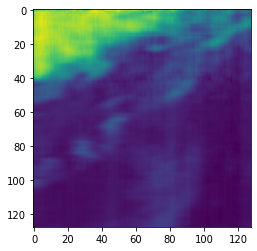

In [ ]:
#The last output is the prediction for the next timestep
plt.imshow(reshape_to_plot(outputs_).cpu().detach().numpy())


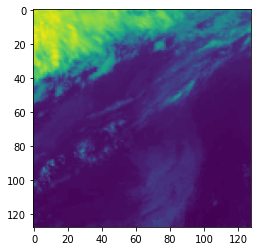

In [ ]:
#The y_val dataset contains the expected image on the last position 
plt.imshow(y_val[-1][0])

Text(0, 0.5, 'loss')

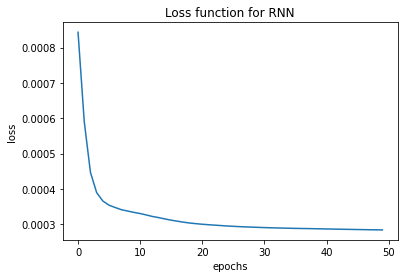

In [ ]:
list_epoch = np.arange(0, 50)
plt.plot(list_epoch, save_loss)
plt.title('Loss function for RNN')
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'SSIM')

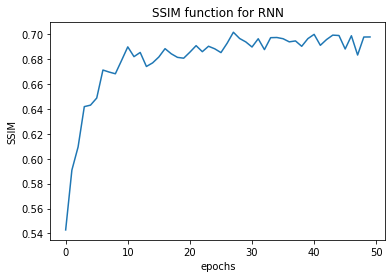

In [ ]:
list_epoch = np.arange(0, 50)
plt.plot(list_epoch, save_acc)
plt.title('SSIM function for RNN')
plt.xlabel('epochs')
plt.ylabel('SSIM')

# PART 2 - LSTM

# Define the neural network - LSTM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
input_dim = 128
hidden_dim = 128
layer_dim = 2
output_dim = 128

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
       
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
       
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.fc(out)
        return out

In [ ]:
import torch
# Define the model
model_LSTM = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.9
optimizer = torch.optim.SGD(model_LSTM.parameters(), lr=learning_rate)

In [ ]:
# Number of steps to unroll
seq_dim = 128
list_outputs = []
list_acc =[]
list_loss = []
iter = 0
for epoch in range(50):
    for i, (images, labels) in enumerate(train_dataloader):
        #print(labels.shape)
        model_LSTM.train()#.to(device )
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()#.to(device )
        labels = labels.view(-1, seq_dim, input_dim).requires_grad_()#.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model_LSTM(images)
        
        # Calculate Loss: 
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model_LSTM.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for k, (images, labels) in enumerate(val_dataloader):
                 #Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim)#.to(device)
                labels = labels.view(-1, seq_dim, input_dim)#.to(device)
                # Forward pass only to get logits/output
                outputs_ = model_LSTM(images)#.to(device)
                list_outputs.append(outputs_)
                
                #Get the metrics
                acc = SSIM_metrics(y_val[k],outputs_)

            # Print Loss
    list_acc.append(acc.item())
    list_loss.append(loss.item())
    print(epoch, loss.item(), acc)
        

We make a plot of the output and of the the term of the y_validation data that corresponds to it. If the model had a perfect accuracy the pictures should be identical. 

The visualization of the plot is a good way to explain the value of SSIM index and gives some sense to it. 

Hence, we can easily see that the model could be strongly improved. A good value of SSIM might be around 0.9.

128 128


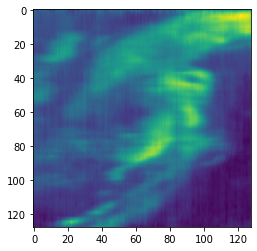

In [ ]:
#The last output is the prediction for the next timestep
plt.imshow(reshape_to_plot(list_outputs[0]).cpu().detach().numpy())


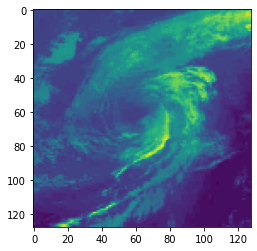

In [ ]:
#The y_val dataset contains the expected image on the last position 
plt.imshow(y_val[0][0])

Text(0, 0.5, 'loss')

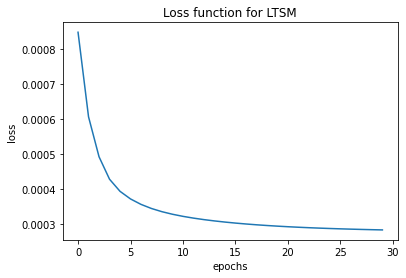

In [ ]:
list_epoch = np.arange(0, 30)
plt.plot(list_epoch, list_loss)
plt.title('Loss function for LTSM')
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'SSIM')

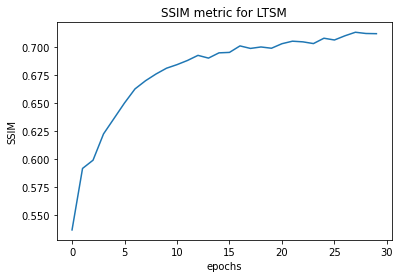

In [ ]:
ssim_list_LSTM = [list_acc[k].item() for k in range(len(list_acc))]
plt.plot(list_epoch, ssim_list_LSTM)
plt.title('SSIM metric for LTSM')
plt.xlabel('epochs')
plt.ylabel('SSIM')

# PART 3 - Surprise storm results on RNN and LSTM

## Extraction of the data and preprocessing

In [ ]:
# # Use this to download the the typical Mac user Downloads folder
#download_dir = Path('~/Downloads').expanduser().resolve()
download_dir = Path('/content').expanduser().resolve()

In [ ]:
# NOTE: Extracting the archives takes a while so this cell may take 5-10 minutes to complete
#archive_paths = dataset.download(output_dir=download_dir)
archive_paths = ['/content/nasa_tropical_storm_competition_surprise_storm_labels.tar.gz','/content/nasa_tropical_storm_competition_surprise_storm_source.tar.gz' ]
for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=download_dir)
print('Done')

Extracting /content/nasa_tropical_storm_competition_surprise_storm_labels.tar.gz...
Extracting /content/nasa_tropical_storm_competition_surprise_storm_source.tar.gz...
Done


In [ ]:
arch_path = ['/content/nasa_tropical_storm_competition_surprise_storm_metrics.tar.gz']
for archive_path in arch_path:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=download_dir)
print('Done')

Extracting /content/nasa_tropical_storm_competition_surprise_storm_metrics.tar.gz...
Done


In [ ]:
train_data = []

train_source = 'nasa_tropical_storm_competition_surprise_storm_source'
train_labels = 'nasa_tropical_storm_competition_surprise_storm_labels'

jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)
    file_name = jpg_path

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed']),
        file_name
    ])

train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'Wind Speed', 'File']
).sort_values(by=['Image ID']).reset_index(drop=True)

train_df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,File
0,sss_001,sss,437401,1,120,/content/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical...
1,sss_002,sss,439200,1,121,/content/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical...
2,sss_003,sss,442800,1,124,/content/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical...
3,sss_004,sss,448200,1,128,/content/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical...
4,sss_005,sss,453600,1,130,/content/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical...


In [ ]:
from IPython.display import Image

## Preprocessing the data

In [ ]:
data_path = '/content/nasa_tropical_storm_competition_surprise_storm_source'
def loader(path):
    return pil_image.open(path)

transform_2 = transforms.Compose([
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Resize(128), 
    ])



from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


train_set_folder = ImageFolder(data_path, transform=transform_2)




In [ ]:
# Each storm is sorted by relative time

split_idx = 93

train_dataframe = train_df.iloc[:split_idx] 

val_dataframe = train_df.iloc[1:split_idx+1] 

test_dataframe = train_df.iloc[split_idx+1:]



In [ ]:
#Save the path of the original images 
list_original_paths = test_dataframe['File']
print(list_original_paths.values[0])

/content/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical_storm_competition_surprise_storm_source_sss_095/image.jpg


Then, we need to create the x_train, y_train and the x_val, y_val. 
Because we want to start by predicting one step ahead the y_train is a copy of the x_train but one step ahead. 

Then we do the same for the validation set 


In [ ]:
# Define the x_train and the y_train set
# The y_train is the x_train with one step ahead
x_train = torch.asarray([train_set_folder[a][0].numpy() for a in list(train_dataframe.index)[:-1]])
y_train = torch.asarray([train_set_folder[a][0].numpy() for a in list(train_dataframe.index)[1:]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Define the validation set in the same way
x_test = torch.asarray([train_set_folder[a][0].numpy() for a in list(test_dataframe.index)[:-1]])
y_test = torch.asarray([train_set_folder[a+1][0].numpy() for a in list(test_dataframe.index)[:-1]])



In [ ]:
#Check the sizes 
print(x_train.shape) 
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([92, 1, 128, 128])
torch.Size([92, 1, 128, 128])
torch.Size([5, 1, 128, 128])
torch.Size([5, 1, 128, 128])


After the definition of the tensors we put everything in a TensorDataset. Those datasets will be the input of the dataloaders.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
#Create train tensor
train_ts = TensorDataset(x_train, y_train)

print('Lenght of train Tensor Dataset', len(train_ts))
print('Size of tensors in the dataset', train_ts[0][0].shape, train_ts[0][1].shape)

# Create validation tensor 
test_ts = TensorDataset(x_test, y_test)
print('Lenght of validation Tensor Dataset', len(test_ts))
print("Size of tensors in the dataset", test_ts[0][0].shape)


Lenght of train Tensor Dataset 92
Size of tensors in the dataset torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
Lenght of validation Tensor Dataset 5
Size of tensors in the dataset torch.Size([1, 128, 128])


In [ ]:
# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(train_ts,batch_size=1,num_workers=2)

test_dataloader = DataLoader(test_ts, batch_size = 1, num_workers = 2)

In [ ]:
def reshape_to_plot(model_output):
  dim = model_output.shape
  print(dim[1], dim[2])
  model_output = model_output.reshape(dim[1],dim[2])
  return(model_output)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RNN 

In [ ]:
import torch.nn as nn


class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(device)
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        
        out = self.fc(out).to(device) 
        
        return out


In [ ]:
input_dim = 128
hidden_dim = 128
layer_dim = 2
output_dim = 128

In [ ]:
model_RNN_1 = RNNModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.9
optimizer = torch.optim.SGD(model_RNN_1.parameters(), lr=learning_rate)

In [ ]:
# Number of steps to unroll
seq_dim = 128
list_outputs = []
iter = 0
# Save the Accuracy         
save_acc = []
save_loss = []
acc = 0
for epoch in range(50):
    for i, (images, labels) in enumerate(train_dataloader):

        model_RNN_1.train().to(device)
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model_RNN_1(images)
        
        # Calculate Loss: 
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model_RNN_1.eval().to(device)
            
            # Iterate through test dataset
            for k, (images, labels) in enumerate(test_dataloader):
                 #Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim).to(device)

                # Forward pass only to get logits/output
                outputs_ = model_RNN_1(images).to(device)
                list_outputs.append(outputs_)
                
                #Get the metrics
                acc = SSIM_metrics(y_test[k].to(device),outputs_)
                
            # Print Loss
    save_acc.append(acc)
    save_loss.append(loss.item())
    print(epoch, loss.item(), acc)
        #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item()))

0 0.010483863763511181 0
1 0.010474834591150284 0
2 0.010468007996678352 0
3 0.010459214448928833 0
4 0.010451478883624077 0
5 0.010447349399328232 tensor(0.4626, device='cuda:0', grad_fn=<SqueezeBackward0>)
6 0.010437997058033943 tensor(0.4626, device='cuda:0', grad_fn=<SqueezeBackward0>)
7 0.010429836809635162 tensor(0.4626, device='cuda:0', grad_fn=<SqueezeBackward0>)
8 0.010426374152302742 tensor(0.4626, device='cuda:0', grad_fn=<SqueezeBackward0>)
9 0.010416304692626 tensor(0.4626, device='cuda:0', grad_fn=<SqueezeBackward0>)
10 0.01041094958782196 tensor(0.4510, device='cuda:0', grad_fn=<SqueezeBackward0>)
11 0.010403260588645935 tensor(0.4510, device='cuda:0', grad_fn=<SqueezeBackward0>)
12 0.01038934662938118 tensor(0.4510, device='cuda:0', grad_fn=<SqueezeBackward0>)
13 0.010382937267422676 tensor(0.4510, device='cuda:0', grad_fn=<SqueezeBackward0>)
14 0.010374613106250763 tensor(0.4510, device='cuda:0', grad_fn=<SqueezeBackward0>)
15 0.010369733907282352 tensor(0.4510, device

Now we want to get the 5 last images predictions

In [ ]:
model_RNN_1.eval()
 
list_outputs = []        
# Iterate through test dataset
for k, (images, labels) in enumerate(test_dataloader):
  #Load images to a Torch tensors with gradient accumulation abilities
  images = images.view(-1, seq_dim, input_dim).to(device)
  labels = labels.view(-1, seq_dim, input_dim)
  # Forward pass only to get logits/output
  outputs_ = model_RNN_1(images)
  list_outputs.append(outputs_)
                
  

In [ ]:
transform_back = torch.nn.Sequential(
    transforms.Resize(366)
)
output_transformed_list = [transform_back(o) for o in list_outputs]


In [ ]:
#Function to display the tensor images 
def tensor_to_PIL(tensor):

  unloader = transforms.ToPILImage()

  image = unloader(tensor)

  display(image)


In [ ]:
from numpy.ma.core import ptp
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from pathlib import Path
from PIL import Image
import numpy as np

def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

# Load target images for comparison
target_1_path = Path(list_original_paths.values[0])
target_2_path = Path(list_original_paths.values[1])
target_3_path = Path(list_original_paths.values[0])
target_4_path = Path(list_original_paths.values[1])
target_5_path = Path(list_original_paths.values[0])

predic_1 = output_transformed_list[0].cpu().detach().numpy()
predic_2 = output_transformed_list[1].cpu().detach().numpy()
predic_3 = output_transformed_list[2].cpu().detach().numpy()
predic_4 = output_transformed_list[3].cpu().detach().numpy()
predic_5 = output_transformed_list[4].cpu().detach().numpy()

# Load images and cast to np arrays, defining datatypes as floats for scale2range function
target_1 = np.array(Image.open(target_1_path), dtype=np.float32) 
target_2 = np.array(Image.open(target_2_path), dtype=np.float32) 
target_3 = np.array(Image.open(target_3_path), dtype=np.float32) 
target_4 = np.array(Image.open(target_4_path), dtype=np.float32) 
target_5 = np.array(Image.open(target_5_path), dtype=np.float32) 
#np.array(Image.open(predic_path), dtype=np.float32)

# Scale predicted image to target range
predic_1 = scale2range(predic_1, [target_1.min(), target_1.max()])
predic_2 = scale2range(predic_2, [target_2.min(), target_2.max()])
predic_3 = scale2range(predic_3, [target_3.min(), target_3.max()])
predic_4 = scale2range(predic_4, [target_4.min(), target_4.max()])
predic_5 = scale2range(predic_5, [target_4.min(), target_4.max()])


# Cast to uint8 to accommodate for consistent SSIM and MSE results
target_1, predic_1 = target_1.astype(np.uint8), predic_1.astype(np.uint8)
target_2, predic_2 = target_2.astype(np.uint8), predic_2.astype(np.uint8)
target_3, predic_3 = target_3.astype(np.uint8), predic_3.astype(np.uint8)
target_4, predic_4 = target_4.astype(np.uint8), predic_4.astype(np.uint8)
target_5, predic_5 = target_5.astype(np.uint8), predic_5.astype(np.uint8)

# Sanity check
print(target_1.dtype, target_1.max(), target_1.min())
print(predic_1.dtype, predic_1.max(), predic_1.min())

# Compute metrics
print('\n SSIM and MSE values \n')
s_1, m_1 = ssim(target_1, predic_1[0]), mse(target_1, predic_1[0])
print('Prediction 1 ', s_1, m_1)
s_2, m_2 = ssim(target_2, predic_2[0]), mse(target_2, predic_2[0])
print("Prediction 2 ", s_2, m_2)
s_3, m_3 = ssim(target_3, predic_3[0]), mse(target_3, predic_3[0])
print("Prediction 3 ", s_3, m_3)
s_4, m_4 = ssim(target_4, predic_4[0]), mse(target_4, predic_4[0])
print("Prediction 4 ", s_4, m_4)
s_5, m_5 = ssim(target_5, predic_5[0]), mse(target_5, predic_5[0])
print("Prediction 5 ", s_5, m_5)

uint8 238 4
uint8 238 4

 SSIM and MSE values 

Prediction 1  0.5466386816388443 485.8655155424169
Prediction 2  0.5489876647210603 469.4307533817074
Prediction 3  0.4359917317741559 957.6264146436143
Prediction 4  0.41443776442570457 1203.2631983636418
Prediction 5  0.39363627013625097 1399.2970229030427


# LSTM

In [ ]:
input_dim = 128
hidden_dim = 128
layer_dim = 2
output_dim = 128

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
        out = self.fc(out)
        return out

In [ ]:
# Number of steps to unroll
seq_dim = 128
list_outputs = []
list_acc =[]
list_loss = []
iter = 0
for epoch in range(50):
    for i, (images, labels) in enumerate(train_dataloader):
        #print(labels.shape)
        model_LSTM.train()#.to(device )
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()#.to(device )
        labels = labels.view(-1, seq_dim, input_dim).requires_grad_()#.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        
        outputs = model_LSTM(images)
        #print(outputs.shape, labels.shape)
        # Calculate Loss: 
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model_LSTM.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for k, (images, labels) in enumerate(test_dataloader):
                 #Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim)#.to(device)
                labels = labels.view(-1, seq_dim, input_dim)#.to(device)
                # Forward pass only to get output
                outputs_ = model_LSTM(images)#.to(device)
                list_outputs.append(outputs_)
                
                

            # Print Loss
    #list_acc.append(acc.item())
    #list_loss.append(loss.item())
    print(epoch, loss.item())
        #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item()))

0 0.026488060131669044
1 0.025511309504508972
2 0.024540800601243973
3 0.023490604013204575
4 0.02188844047486782
5 0.020125359296798706
6 0.018671955913305283
7 0.017395419999957085
8 0.016276415437459946
9 0.015393315814435482
10 0.014767794869840145
11 0.014341975562274456
12 0.014030982740223408
13 0.013770739547908306
14 0.013531641103327274
15 0.013308527879416943
16 0.013107729144394398
17 0.012935558333992958
18 0.012792336754500866
19 0.01267335843294859
20 0.012572611682116985
21 0.012484986335039139
22 0.012406774796545506
23 0.012335451319813728
24 0.012269371189177036
25 0.012207486666738987
26 0.012149151414632797
27 0.01209398452192545
28 0.012041750364005566
29 0.011992281302809715


In [ ]:
print(outputs_)

tensor([[[0.3108, 0.3380, 0.3271,  ..., 0.1572, 0.1538, 0.1569],
         [0.4294, 0.4610, 0.4572,  ..., 0.1779, 0.1734, 0.1731],
         [0.4893, 0.5148, 0.5171,  ..., 0.1725, 0.1731, 0.1699],
         ...,
         [0.0616, 0.0587, 0.0597,  ..., 0.0615, 0.0582, 0.0598],
         [0.0590, 0.0569, 0.0587,  ..., 0.0612, 0.0580, 0.0602],
         [0.0598, 0.0571, 0.0590,  ..., 0.0586, 0.0559, 0.0576]]],
       grad_fn=<AddBackward0>)


In [ ]:
model_LSTM.eval()
 
list_outputs = []        
# Iterate through test dataset
for k, (images, labels) in enumerate(test_dataloader):
  #Load images to a Torch tensors with gradient accumulation abilities
  images = images.view(-1, seq_dim, input_dim)
  labels = labels.view(-1, seq_dim, input_dim)
  # Forward pass only to get logits/output
  outputs_ = model_LSTM(images)
  list_outputs.append(outputs_)
                

In [ ]:
# Back to the intial size
transform_back = torch.nn.Sequential(
    transforms.Resize(366)
)
output_transformed_list = [transform_back(o) for o in list_outputs]


In [ ]:
from numpy.ma.core import ptp
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from pathlib import Path
from PIL import Image
import numpy as np

def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

# Load target images for comparison
target_1_path = Path(list_original_paths.values[0])
target_2_path = Path(list_original_paths.values[1])
target_3_path = Path(list_original_paths.values[0])
target_4_path = Path(list_original_paths.values[1])
target_5_path = Path(list_original_paths.values[0])

predic_1 = output_transformed_list[0].cpu().detach().numpy()
predic_2 = output_transformed_list[1].cpu().detach().numpy()
predic_3 = output_transformed_list[2].cpu().detach().numpy()
predic_4 = output_transformed_list[3].cpu().detach().numpy()
predic_5 = output_transformed_list[4].cpu().detach().numpy()

# Load images and cast to np arrays, defining datatypes as floats for scale2range function
target_1 = np.array(Image.open(target_1_path), dtype=np.float32) 
target_2 = np.array(Image.open(target_2_path), dtype=np.float32) 
target_3 = np.array(Image.open(target_3_path), dtype=np.float32) 
target_4 = np.array(Image.open(target_4_path), dtype=np.float32) 
target_5 = np.array(Image.open(target_5_path), dtype=np.float32) 
#np.array(Image.open(predic_path), dtype=np.float32)

# Scale predicted image to target range
predic_1 = scale2range(predic_1, [target_1.min(), target_1.max()])
predic_2 = scale2range(predic_2, [target_2.min(), target_2.max()])
predic_3 = scale2range(predic_3, [target_3.min(), target_3.max()])
predic_4 = scale2range(predic_4, [target_4.min(), target_4.max()])
predic_5 = scale2range(predic_5, [target_4.min(), target_4.max()])


# Cast to uint8 to accommodate for consistent SSIM and MSE results
target_1, predic_1 = target_1.astype(np.uint8), predic_1.astype(np.uint8)
target_2, predic_2 = target_2.astype(np.uint8), predic_2.astype(np.uint8)
target_3, predic_3 = target_3.astype(np.uint8), predic_3.astype(np.uint8)
target_4, predic_4 = target_4.astype(np.uint8), predic_4.astype(np.uint8)
target_5, predic_5 = target_5.astype(np.uint8), predic_5.astype(np.uint8)

# Sanity check
print(target_1.dtype, target_1.max(), target_1.min())
print(predic_1.dtype, predic_1.max(), predic_1.min())

# Compute metrics
print('\n SSIM and MSE values \n')
s_1, m_1 = ssim(target_1, predic_1[0]), mse(target_1, predic_1[0])
print('Prediction 1 ', s_1, m_1)
s_2, m_2 = ssim(target_2, predic_2[0]), mse(target_2, predic_2[0])
print("Prediction 2 ", s_2, m_2)
s_3, m_3 = ssim(target_3, predic_3[0]), mse(target_3, predic_3[0])
print("Prediction 3 ", s_3, m_3)
s_4, m_4 = ssim(target_4, predic_4[0]), mse(target_4, predic_4[0])
print("Prediction 4 ", s_4, m_4)
s_5, m_5 = ssim(target_5, predic_5[0]), mse(target_5, predic_5[0])
print("Prediction 5 ", s_5, m_5)

uint8 238 4
uint8 238 4

 SSIM and MSE values 

Prediction 1  0.48709210931046043 611.4331422258055
Prediction 2  0.49022937778039327 651.5609229896384
Prediction 3  0.44547816900418563 953.3548478604915
Prediction 4  0.4300666923815042 1112.8951894651975
Prediction 5  0.41806249443275667 1256.1170458956672


# PART 4 - Multiple timestep forecasting strategies

1 . Direct multi-step forecasting

The direct method involves developing a separate model for each forecast time step.

For example:
prediction(t+1) = model1(obs(t-1), obs(t-2), ..., obs(t-n)) prediction(t+2) = model2(obs(t-2), obs(t-3), ..., obs(t-n))
Having one model for each time step is an added computational and maintenance burden, especially as the number of time steps to be forecasted increases beyond the trivial.
Because separate models are used, it means that there is no opportunity to model the dependencies between the predictions, such as the prediction on day 2 being dependent on the prediction in day 1, as is often the case in time series.

In [ ]:
# Define the x_train and the y_train set
# The y_train is the x_train with one step ahead
x_train_3 = torch.asarray([train_set_folder[a][0].numpy() for a in list(fcr_dataframe.index)[:split-3]])
y_train_3 = torch.asarray([train_set_folder[a+3][0].numpy() for a in list(fcr_dataframe.index)[:split-3]])

x_val_3 = torch.asarray([train_set_folder[a][0].numpy() for a in list(fcr_dataframe.index)[split-2:]])
y_val_3 = torch.asarray([train_set_folder[a+3][0].numpy() for a in list(fcr_dataframe.index)[split-2:]])

In [ ]:
print(x_train_3.shape, y_train_3.shape)

torch.Size([515, 1, 128, 128]) torch.Size([515, 1, 128, 128])


In [ ]:
#Create train tensor
train_ts_3 = TensorDataset(x_train_3, y_train_3)

print(len(train_ts_3))
print(train_ts_3[0][0].shape, train_ts_3[0][1].shape)

# Create validation tensor 
val_ts_3 = TensorDataset(x_val_3, y_val_3)
print(len(val_ts_3))
print(val_ts_3[0][0].shape)

515
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])
132
torch.Size([1, 128, 128])


In [ ]:
# Create the dataloaders
train_dataloader_3 = torch.utils.data.DataLoader(train_ts_3,batch_size=1,num_workers=2)

val_dataloader_3 = DataLoader(val_ts_3, batch_size = 1, num_workers = 2)

In [ ]:
input_dim = 128
hidden_dim = 128
layer_dim = 2
output_dim = 128

In [ ]:
class RNNModel_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel_2, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        h0 =h0.to(device)
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        out = self.fc(out).to(device) 
        
        return out


In [ ]:
model_RNN_2 = RNNModel_2(input_dim, hidden_dim, layer_dim, output_dim).to(device)
criterion = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.9
optimizer = torch.optim.SGD(model_RNN_2.parameters(), lr=learning_rate)

In [ ]:
#Number of steps to unroll
seq_dim = 128
list_outputs = []
iter = 0
for epoch in range(10):
    for i, (images, labels) in enumerate(train_dataloader_3):
        #print(labels.shape)
        model_RNN_2.train().to(device)
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        labels = labels.view(-1, seq_dim, input_dim).requires_grad_().to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
       
        outputs = model_RNN_2(images).to(device)
        #print(outputs.shape, labels.shape)
        # Calculate Loss: softmax 
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model_RNN_2.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for k, (images, labels) in enumerate(val_dataloader_3):
                 #Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim).to(device)
                #labels = labels.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs_ = model_RNN_2(images).to(device)
                list_outputs.append(outputs_)
                
                #Get the metrics
                acc = SSIM_metrics(y_val_3[k].to(device),outputs_)

            # Print Loss
    print(epoch, loss.item(), acc.item())
        #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item()))

0 0.0007170704775489867 0.12852707505226135
1 0.0006044362671673298 0.1349543035030365
2 0.0005513280630111694 0.1457843780517578
3 0.0005316090537235141 0.14394481480121613
4 0.0005240907776169479 0.14669117331504822
5 0.0005207420908845961 0.15262331068515778
6 0.0005190257797949016 0.1558026671409607
7 0.000518082408234477 0.148837611079216
8 0.0005175704136490822 0.15146225690841675
9 0.0005173097015358508 0.15014880895614624


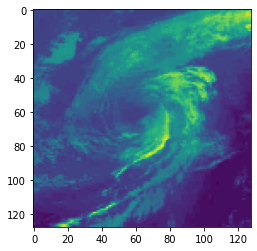

In [ ]:
#The y_val dataset contains the expected image on the last position 
plt.imshow(y_val_3[1][0])

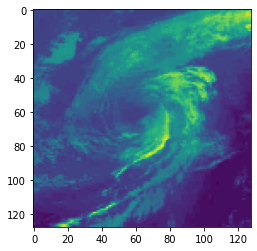

In [ ]:
plt.imshow(x_val_3[4][0])

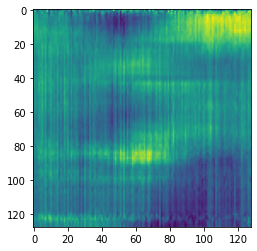

In [ ]:
plt.imshow(list_outputs[1].reshape(128,128).cpu().detach().numpy())

Let's try with the LSTM

In [ ]:
# Number of steps to unroll
seq_dim = 128
list_outputs = []
iter = 0
for epoch in range(10):
    for i, (images, labels) in enumerate(train_dataloader_3):
        #print(labels.shape)
        model_LSTM.train()
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        labels = labels.view(-1, seq_dim, input_dim).requires_grad_()
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model_LSTM(images)
        #print(outputs.shape, labels.shape)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model_LSTM.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for k, (images, labels) in enumerate(val_dataloader_3, 4):
                 #Load images to a Torch tensors with gradient accumulation abilities
                images = images.view(-1, seq_dim, input_dim)
                labels = labels.view(-1, seq_dim, input_dim)
                # Forward pass only to get logits/output
                outputs_ = model_LSTM(images) 
                list_outputs.append(outputs_)
                
                #Get the metrics
                acc = SSIM_metrics(y_val_3[k-4],outputs_)

            # Print Loss
    print(epoch, loss.item(), acc)
        #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item()))

0 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
1 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
2 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
3 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
4 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
5 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
6 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
7 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
8 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)
9 0.0004739148134831339 tensor(0.1422, grad_fn=<SqueezeBackward0>)


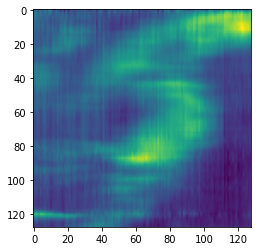

In [ ]:
#The last output is the prediction for the next timestep
plt.imshow(list_outputs[0].reshape(128, 128).detach().numpy())

We can notice the prediction is a bit better with the LSTM than with the RNN. It is probably due to the stronger memory of LSTM compared to the RNN.



2. Recursive Multi-step Forecast

The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.

In the case of predicting the temperature for the next two days, we would develop a one-step forecasting model. This model would then be used to predict day 1, then this prediction would be used as an observation input in order to predict day 2.

For example:

prediction(t+1) = model(obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+2) = model(prediction(t+1), obs(t-1), ..., obs(t-n))

Because predictions are used in place of observations, the recursive strategy allows prediction errors to accumulate such that performance can quickly degrade as the prediction time horizon increases.

In [ ]:
#Got the prediction
# With a basic loop we are doing a prediction based on the last one, 5 times 
for k in range (5):
  model_RNN_1.eval().to(device)
  preds =  model_RNN_1(outputs_).to(device)
  outputs_ = preds.to(device)

print(preds.shape)

torch.Size([1, 128, 128])


Let's do the same for LSTM

In [ ]:
#Got the prediction
# With a basic loop we are doing a prediction based on the last one, 5 times 
for k in range (5):
  model_LSTM.eval()
  preds =  model_LSTM(outputs_)
  outputs_ = preds

print(preds.shape)

128 128


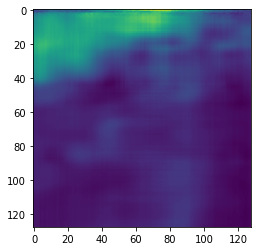

In [ ]:
#The last output is the prediction for the next timestep
plt.imshow(reshape_to_plot(preds).cpu().detach().numpy())

We can observe that the image quality is very low, the recursive multistep forecast therefore accumulates the errors.